In [1]:
import numpy as np
import matplotlib.pyplot as plt
import plumed
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
import math

# Short analysis of the biased run

## O-Ca2+ distance as a function of time

/var/folders/hn/315sv5754l3bwzn1_mtrpscc0000gn/T/ipykernel_1709/2125661063.py:1: UserWarning: cannot load PLUMED instance, conversions will not be available
  data_hills = plumed.read_as_pandas("HILLS")


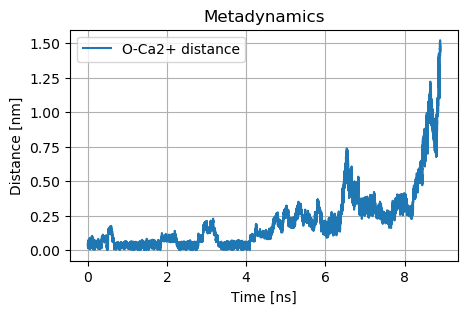

In [3]:
data_hills = plumed.read_as_pandas("HILLS")
plt.rcParams["figure.figsize"] = (5, 3)
plt.plot(data_hills["time"]*0.001, data_hills["d1"], label="O-Ca2+ distance")
plt.xlabel("Time [ns]")
plt.ylabel("Increment of bias potential [kJ/mol]")
plt.grid()
plt.title("Metadynamics")
plt.ylabel("Distance [nm]")
plt.xlabel("Time [ns]")
plt.legend(loc="best")

## Metadynamics reweighting bias $\beta[V(s,t) - c(t)]$ 

/var/folders/hn/315sv5754l3bwzn1_mtrpscc0000gn/T/ipykernel_1709/3904181208.py:1: UserWarning: cannot load PLUMED instance, conversions will not be available
  data_colvar = plumed.read_as_pandas("COLVAR")


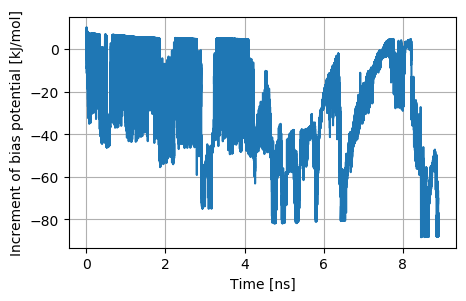

In [4]:
data_colvar = plumed.read_as_pandas("COLVAR")
plt.plot(data_colvar["time"]*0.001, data_colvar["metad.rbias"])
plt.xlabel("Time [ns]")
plt.ylabel("Increment of bias potential [kJ/mol]")
plt.grid()

# Acceleration factor $\langle e^{\beta V(s, t)}\rangle$

/var/folders/hn/315sv5754l3bwzn1_mtrpscc0000gn/T/ipykernel_1709/3957625089.py:1: UserWarning: cannot load PLUMED instance, conversions will not be available
  data_acc = plumed.read_as_pandas("ACC")


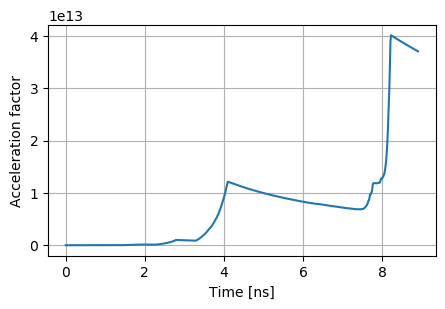

In [6]:
data_acc = plumed.read_as_pandas("ACC")
plt.plot(data_colvar["time"]*0.001, data_acc["metad.acc"])
plt.xlabel("Time [ns]")
plt.ylabel("Acceleration factor")
plt.grid()

Notice that the value of the acceleration factor increases drastically after approximately 8 ns. Now, according to 

$$\tau_{\text{dep}}(t)=\text{min}\left\{\tau_0 \text{max}\left( \frac{\alpha(t)}{\theta}, 1 \right), \tau_c\right\}$$

since we have `FA_MIN_ACCELERATION=100000`. This should lead to $\tau_{dep}(t)=5000$ (i.e., the `FA_MAX_PACE` we have imposed in our script), whenever t>8 ns. But this does not happen, as you can see from the below plot of the Gaussian deposition pace. Instead, the frequency seems to remain fixed at 100.

# Pace of Gaussian deposition

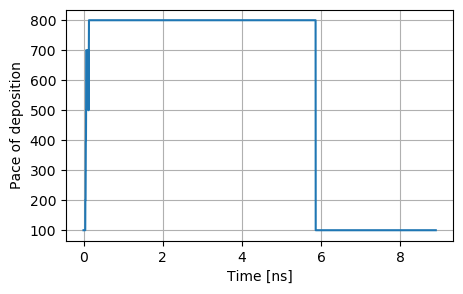

In [15]:
plt.plot(data_colvar["time"]*0.001, data_colvar["metad.pace"])
plt.xlabel("Time [ns]")
plt.ylabel("Pace of deposition")
plt.grid()

# Comparison between free energy surfaces
We use the tool `sum_hills` to judge the convergence of the free energy profile as a function of the simulated time. With this command we generate many free energy files (`fes`), each one containing the estimate of the free energy up to that point in time.
```
plumed sum_hills --hills HILLS --mintozero
```

/var/folders/hn/315sv5754l3bwzn1_mtrpscc0000gn/T/ipykernel_1709/1810763805.py:1: UserWarning: cannot load PLUMED instance, conversions will not be available
  data_fes = plumed.read_as_pandas("fes.dat")


(0, 1.5)

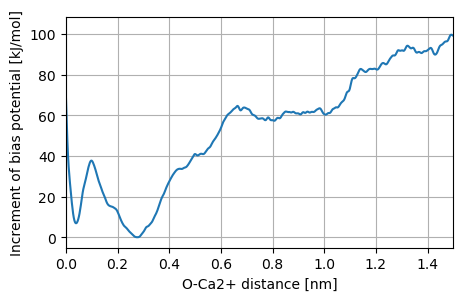

In [10]:
data_fes = plumed.read_as_pandas("fes.dat")
plt.plot(data_fes["d1"], data_fes["file.free"])
plt.xlabel("O-Ca2+ distance [nm]")
plt.ylabel("Increment of bias potential [kJ/mol]")
plt.grid()
plt.xlim([0, 1.5])

## Biased and unbiased histograms as a function of O-Ca2+ distance
Here we consider the COLVAR file. Remember that the COLVAR file has more samples than the HILLS file. since the deposition PACE of the run is bigger than 100 (STRIDE for COLVAR). We expect the unbiased distribution to be very similar to the distribution of the first run without metadynamics. Be careful: always use $kT=1$ because plumed always expresses quantities multiplied by $\beta$. 

IMPORTANT: note that `sum_hills` is just summing the Gaussians to reconstruct the free energy as (proportional to) the applied potential.

Text(0, 0.5, 'Probability density')

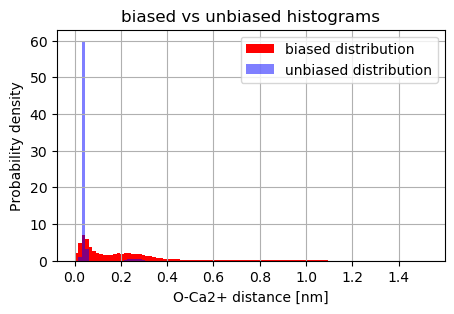

In [8]:
val_bias, bins_bias, patches_bias = plt.hist(data_colvar["d1"], bins=100, density=True, color='r', label="biased distribution")
kT = 1
w = [math.exp(data_colvar["metad.rbias"][i])/kT for i in range(len(data_colvar["metad.rbias"]))]
val_unbias, bins_unbias, patches_unbias = plt.hist(data_colvar["d1"], bins=100, weights=w, density=True, alpha = 0.5, color= 'b', label="unbiased distribution")
plt.grid()
plt.legend(loc="best")
plt.title("biased vs unbiased histograms")
plt.xlabel("O-Ca2+ distance [nm]")
plt.ylabel("Probability density")

# Note that len(bins_bias) = len(val_bias) + 1 because bins_bias contains the edges of the bins

Text(0, 0.5, 'Free energy surface')

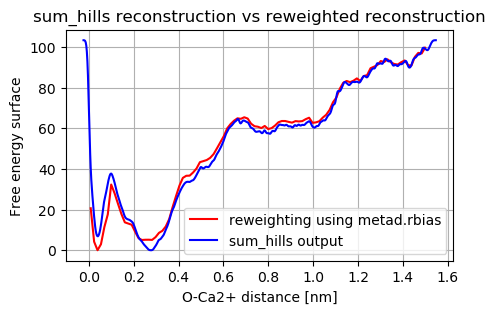

In [9]:
F = []
dist = []
kT = 1
mesh = (bins_unbias[1] - bins_unbias[0])/2
i = 0
min = -kT * math.log(val_unbias[0])

while val_unbias[i] != 0 and i<len(val_unbias)-1:
    F.append(-kT * math.log(val_unbias[i]))
    dist.append(bins_unbias[i] + mesh)
    if F[i] < min:
        min = F[i]
    i = i + 1

# Remove the offset
F = F - min*np.ones(len(F))

# From the fes.dat file (elaboration of the HILLS file, via sum_hills)
plt.plot(dist, F, 'r',label="reweighting using metad.rbias")
plt.plot(data_fes["d1"], data_fes["file.free"], 'b', label="sum_hills output")
plt.grid()
plt.legend(loc="best")
plt.title("sum_hills reconstruction vs reweighted reconstruction")
plt.xlabel("O-Ca2+ distance [nm]")
plt.ylabel("Free energy surface")


# The small difference is due to the arbitrary shift